Import package

In [12]:
import os
import glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt


Define input difrectory and loop through images

In [13]:
# Define the directory where your images are stored
image_directory = 'C:/Users/pichaya/Gruming/data/input'

# Find all the images (e.g., .tif files) in the directory
search_criteria = "*.tif"
search_path = os.path.join(image_directory, search_criteria)
image_files = glob.glob(search_path)

# Initialize an empty dictionary to store band data
band_data_dict = {}


Loop through images

In [14]:
# Loop through the images and read the band data and descriptions
for image_file in image_files:
    with rasterio.open(image_file) as src:
        num_bands = src.count
        for band_index in range(1, num_bands + 1):
            band_data = src.read(band_index)
            if band_index not in band_data_dict:
                band_data_dict[band_index] = [band_data]             
            else:
                band_data_dict[band_index].append(band_data)

calculate ndwi for the water mask and calculate statistics; min, mean, median, std and plot out results

C:\Users\pichaya\AppData\Local\Temp\ipykernel_408\1619938291.py:14: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(band_data_array_masked, axis=0)
C:\Users\pichaya\AppData\Local\Temp\ipykernel_408\1619938291.py:16: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(band_data_array_masked, axis=0)


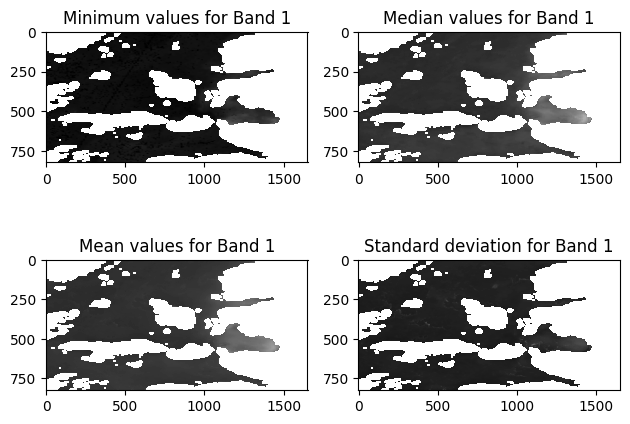

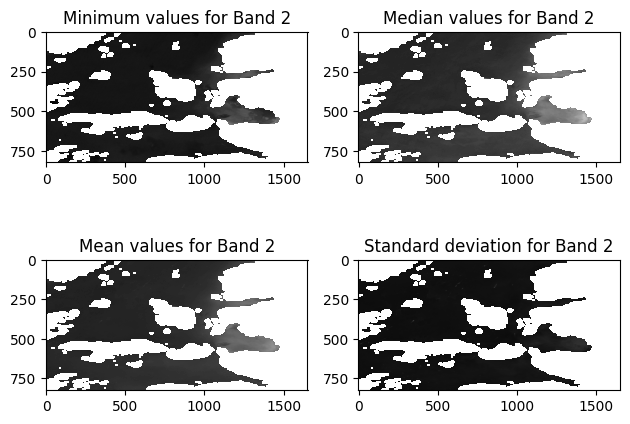

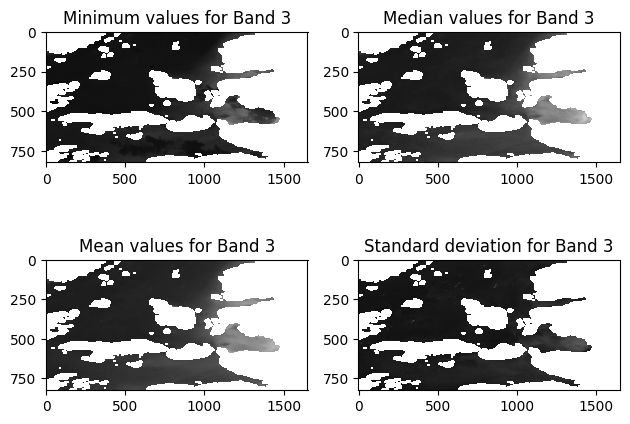

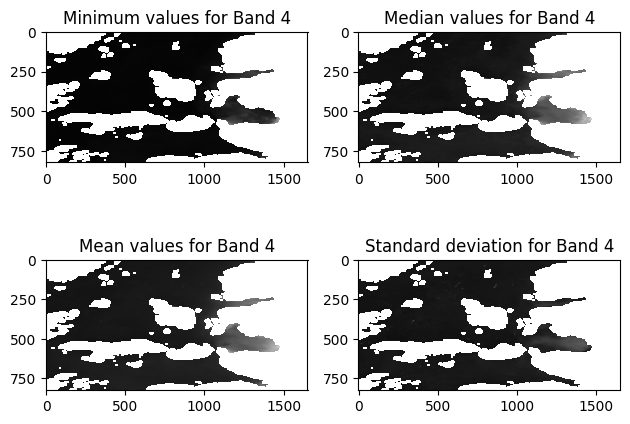

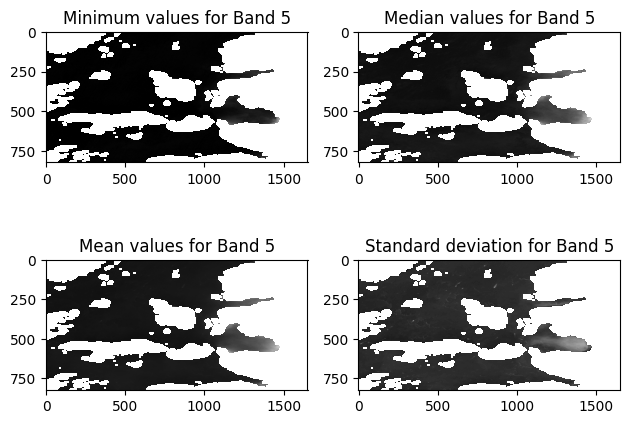

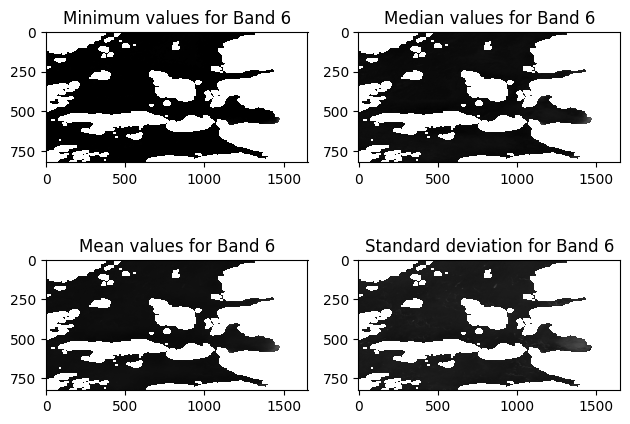

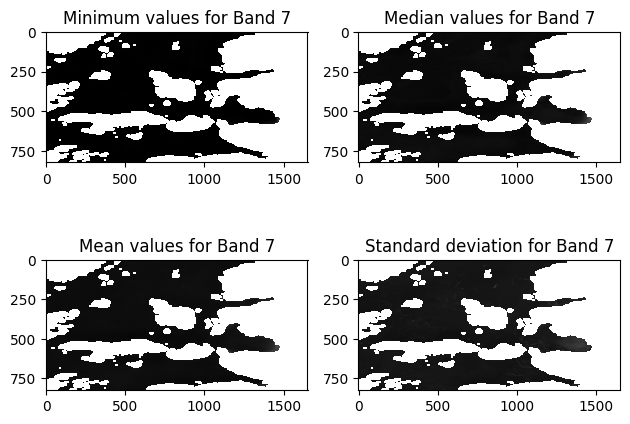

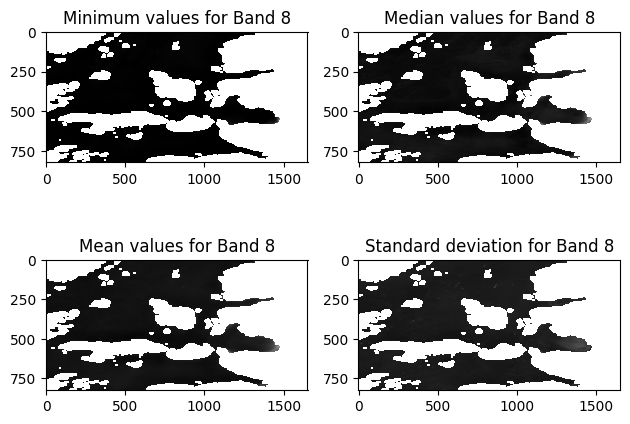

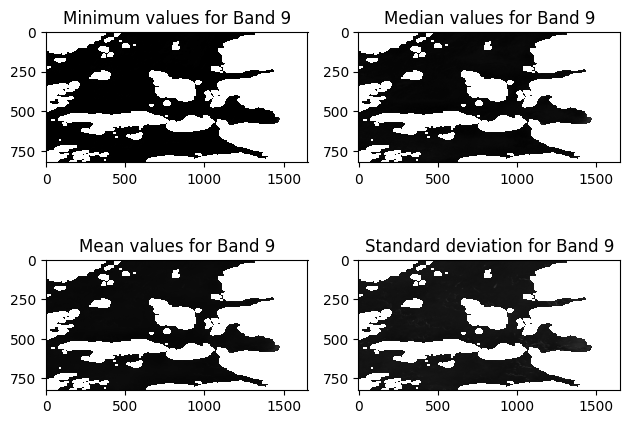

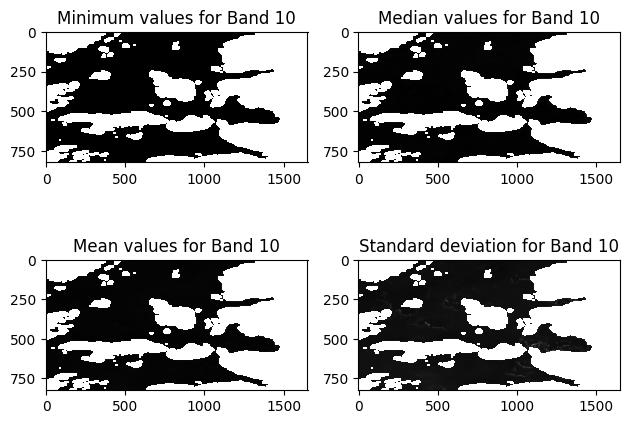

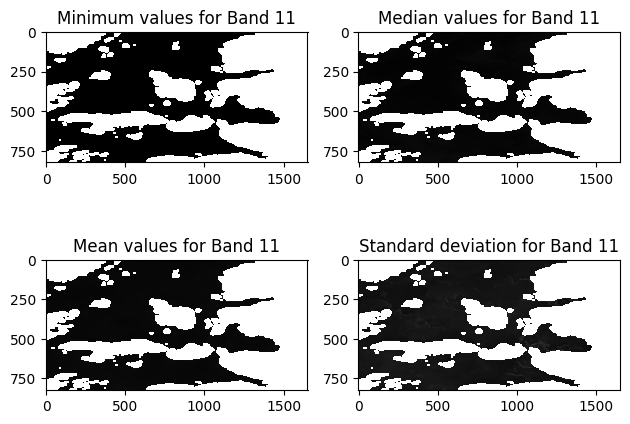

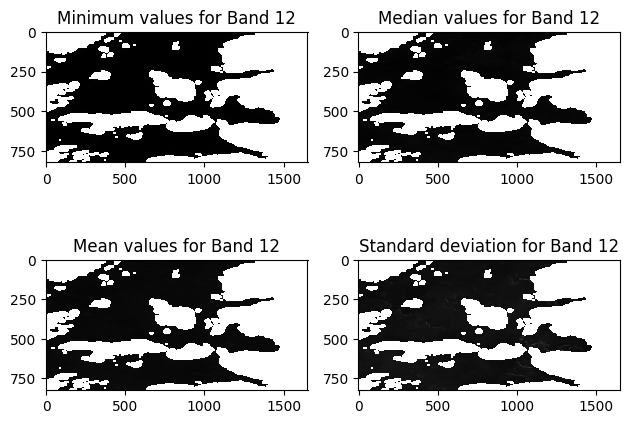

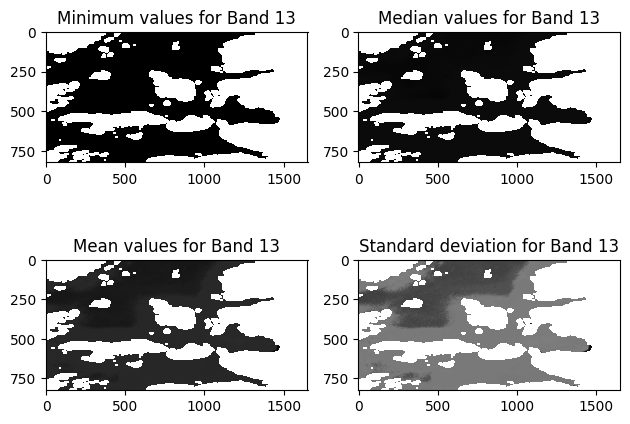

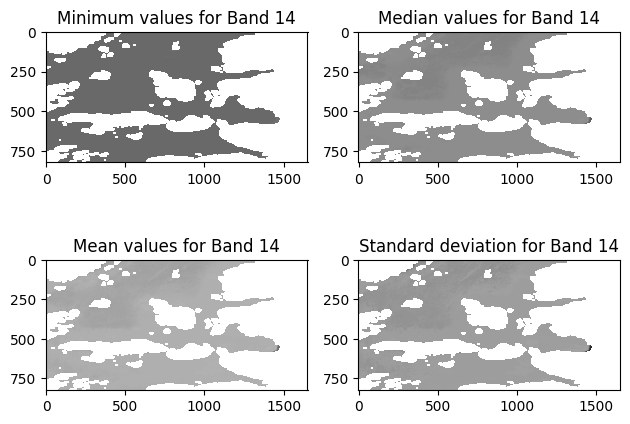

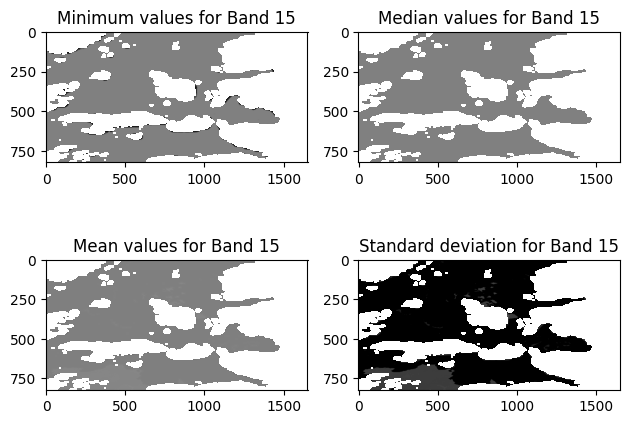

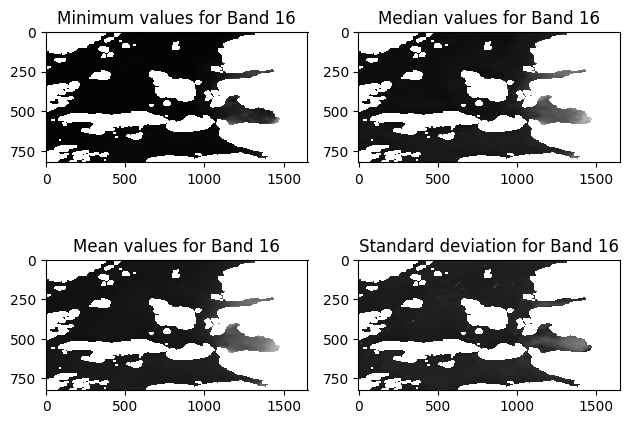

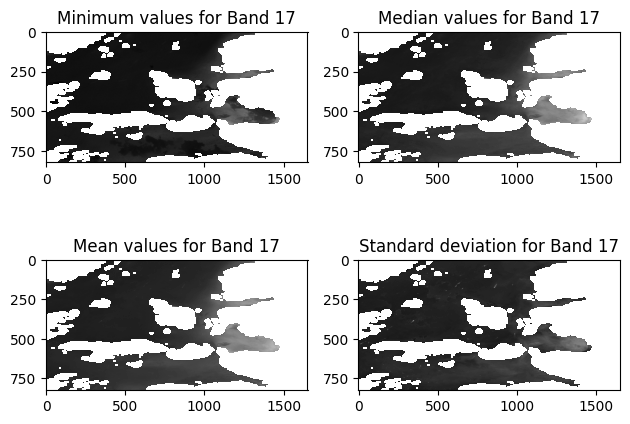

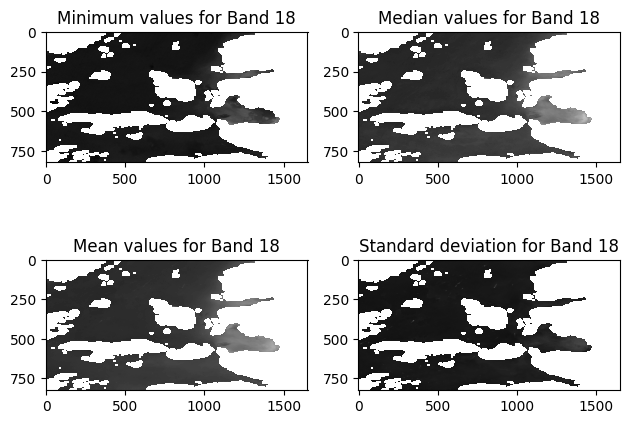

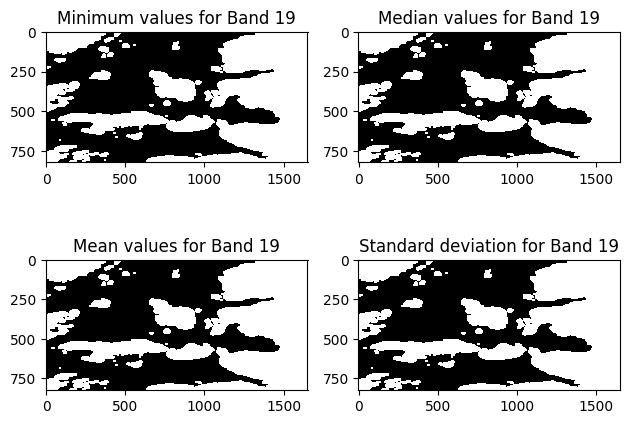

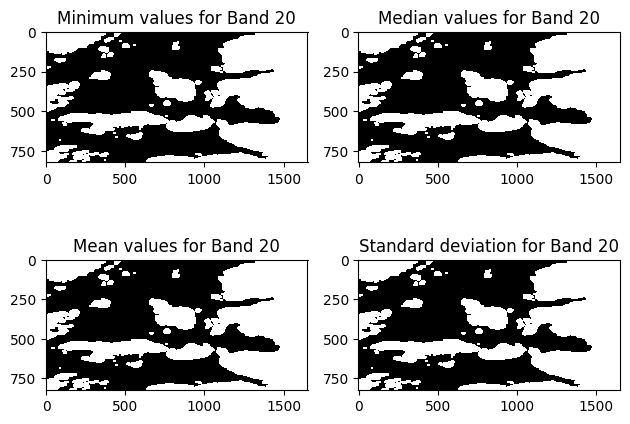

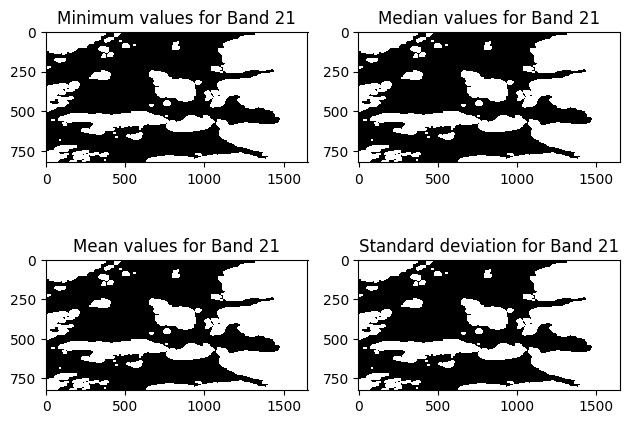

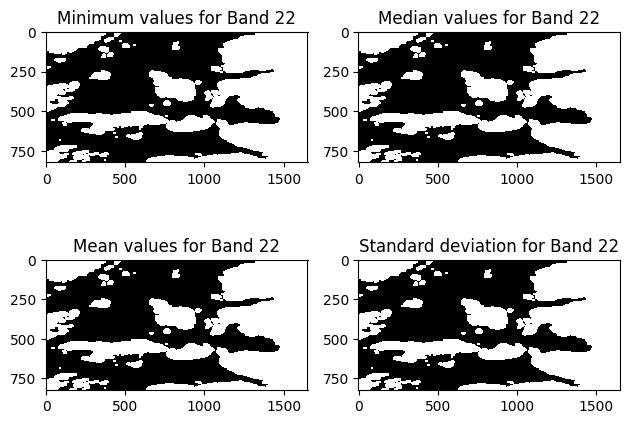

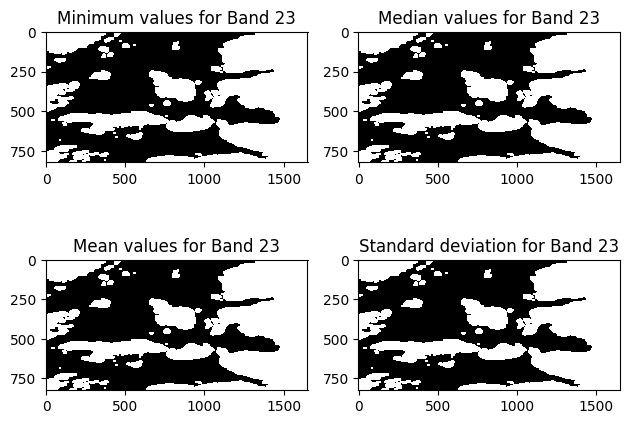

In [15]:
# Calculate NDWI using bands 8 and 12 (replace these indices if needed)
green_band = np.stack(band_data_dict[3], axis=0)
nir_band = np.stack(band_data_dict[8], axis=0)
ndwi = (green_band - nir_band) / (green_band + nir_band)

# Create a binary mask for water areas (you can adjust the threshold if needed)
water_mask = ndwi > 0.2

# Calculate the statistics for each band and visualize the results
for band_index, band_data in band_data_dict.items():
    band_data_array = np.stack(band_data, axis=0)
    band_data_array_masked = np.where(water_mask, band_data_array, np.nan)
    
    min_values = np.nanmin(band_data_array_masked, axis=0)
    median = np.nanmedian(band_data_array_masked, axis=0)
    mean = np.nanmean(band_data_array_masked, axis=0)
    std = np.nanstd(band_data_array_masked, axis=0)
    
    # Plot the statistics
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].imshow(min_values, cmap='gray')
    axs[0, 0].set_title(f'Minimum values for Band {band_index}')
    axs[0, 1].imshow(median, cmap='gray')
    axs[0, 1].set_title(f'Median values for Band {band_index}')
    axs[1, 0].imshow(mean, cmap='gray')
    axs[1, 0].set_title(f'Mean values for Band {band_index}')
    axs[1, 1].imshow(std, cmap='gray')
    axs[1, 1].set_title(f'Standard deviation for Band {band_index}')
    plt.tight_layout()
    plt.show()


save the statistics results as GeoTIFF files with the same projection as the input images

In [18]:
#define a function to save the GeoTIFF files
def save_geotiff(output_path, data, src_profile):
    with rasterio.open(output_path, 'w', **src_profile) as dst:
        dst.write(data)

    # Save the statistics as GeoTIFF files
    output_directory = 'C:/Users/pichaya/Gruming/data/output'
    os.makedirs(output_directory, exist_ok=True)
    with rasterio.open(image_files[0]) as src:
        src_profile = src.profile.copy()
        src_profile.update(dtype=rasterio.float32, count=1)
    save_geotiff(os.path.join(output_directory, f'band_{band_index}_min.tif'), min_values.astype(rasterio.float32), src_profile)
    save_geotiff(os.path.join(output_directory, f'band_{band_index}_median.tif'), median.astype(rasterio.float32), src_profile)
    save_geotiff(os.path.join(output_directory, f'band_{band_index}_mean.tif'), mean.astype(rasterio.float32), src_profile)
    save_geotiff(os.path.join(output_directory, f'band_{band_index}_std.tif'), std.astype(rasterio.float32), src_profile)